In [11]:
from block_bootstrap_simulation_1v import run_bootstrap_simulation_single
import pandas as pd
import numpy as np

In [19]:

data = pd.read_csv("../data/processed/tmax2m_sp_point.csv", parse_dates=["date"])
data = data.set_index("date")

y = data['tmax2m'].values
y = y - np.nanmean(y)

n = len(y)
autocorr = np.array([np.corrcoef(y[:-lag], y[lag:])[0,1] for lag in range(1, n//2)])

weights = 1 - np.arange(1, len(autocorr)+1) / len(autocorr)
T0 = 1 + 2 * np.sum(weights * autocorr)

print("T0 (en días):", T0)

block_size = int(np.ceil(T0))

T0 (en días): 2.1859190434837874


In [20]:


run_bootstrap_simulation_single(
    data=data,
    variable="tmax2m",
    n_simulations=1000,
    block_length=block_size,
    window_days=20,
    output_dir="../data/processed/bootstrap_tmax2m"
)

100%|██████████| 1000/1000 [00:00<00:00, 727925.03it/s]

✅ Completed 1000 simulations for tmax2m


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define paths
results_dir = '../data/processed/bootstrap_tmax2m/'

# Read all result files
aep_temp = pd.read_csv(f'{results_dir}aep_curve_tmax2m.csv')
sim_daily_temp = pd.read_csv(f'{results_dir}daily_simulations_tmax2m.csv')
summary_stats = pd.read_csv(f'{results_dir}summary_stats_tmax2m.csv')


<Axes: >

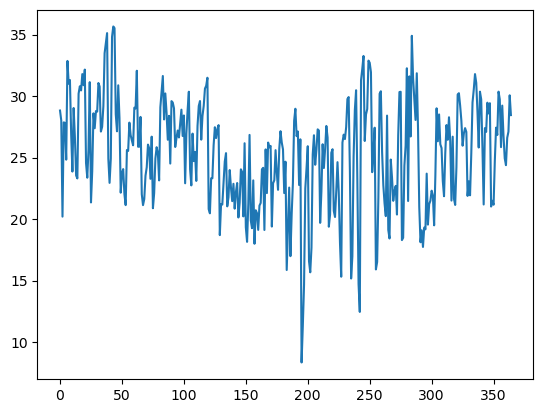

In [22]:
sim_daily_temp['sim_0000'].plot()

In [23]:
n_sims = len([col for col in sim_daily_temp.columns if col.startswith('sim_')])

sim_dfs = []

for i in range(n_sims):
    sim_num = f'{i:04d}'
    temp_col = f'sim_{sim_num}'
    
    sim_data = pd.DataFrame({
        'temperature': sim_daily_temp[temp_col]
    })
    
    sim_data['simulation'] = i
    
    sim_dfs.append(sim_data)

sim_df_reshaped = pd.concat(sim_dfs, axis=0).reset_index(drop=True)

print(sim_df_reshaped.head())

print(sim_df_reshaped.tail())

   temperature  simulation
0    28.820220           0
1    28.012848           0
2    20.200592           0
3    27.858307           0
4    27.822174           0
        temperature  simulation
364995    30.856842         999
364996    31.459381         999
364997    30.751130         999
364998    28.532623         999
364999    24.950104         999


In [ ]:
## check this block for pricing identification

fraction_brave_riders = 0.6     # relation between brave riders and total riders
fraction_hw_wage = 3            # relation between heat wave wage and normal wage

total_riders = 20000
normal_wage = 1

brave_riders = int(total_riders * fraction_brave_riders)
no_brave_riders = total_riders - brave_riders

hw_wage = normal_wage * fraction_hw_wage

daily_loss = total_riders * normal_wage - (brave_riders * hw_wage)

threshold_temperature = 34

print("threshold_temp:", threshold_temperature)

sim_df_reshaped['cond_temp'] = (sim_df_reshaped['temperature'] > threshold_temperature).astype(int)

def _mark_runs(series, min_len=3):
    cond = series.astype(bool)
    runs = (cond != cond.shift()).cumsum()
    run_sizes = cond.groupby(runs).transform('size')
    return ((cond) & (run_sizes >= min_len)).astype(int)

sim_df_reshaped['event'] = sim_df_reshaped.groupby('simulation', group_keys=False)['cond_temp'].apply(_mark_runs)

sim_df_reshaped['loss'] = daily_loss * sim_df_reshaped['event']    

total_dias = len(sim_df_reshaped)

frac_event = sim_df_reshaped['event'].sum() / total_dias

print(f"Ambos (event): {frac_event:.3%}")

threshold_temp: 34

Fracción de días con evento (respecto al total):
Ambos (event): 0.166%


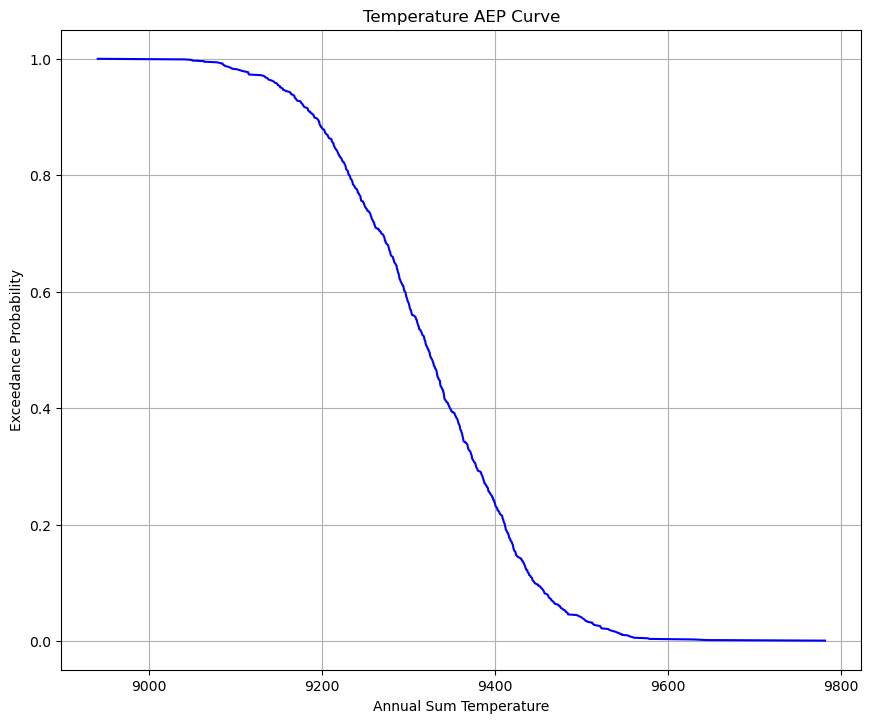

In [25]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes([0.05, 0.05, 0.8, 0.8])

ax.plot( aep_temp['annual_sum'], aep_temp['exceedance_probability'], 'b-')
ax.set_ylabel('Exceedance Probability')
ax.set_xlabel('Annual Sum Temperature')
ax.set_title('Temperature AEP Curve')
ax.grid()
